<h1> Ship Type Prediction </h1>

<p align='justify'>

This Jupyter notebook contains a classification example which is
done with the help of Scikit-Learn library. In this notebook,
the following steps are performed:
</p>

<ol align='justify'>
    <li> The preprocessing i.e. feature generation, filtering and
         interpolation of the data is carried out using the
         PTRAIL Library.
    </li>
    <li> Further, several models like RandomForestClassifier, KMeans
         Classifier etc. are trained using the Scikit-Learn library
         based on the cleaned dataset.
    </li>
    <li>
        Finally, on the interpolated dataset, the type of ships are
        predicted and their accuracy is checked.
    </li>

In [4]:
# We are going to supress any UserWarnings for demonstration purposes.
import warnings
warnings.simplefilter("ignore", UserWarning)

# Load the data into a pandas dataframe and convert it into a PTRAILDataFrame.
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics

pdf = pd.read_csv('../data/ships.csv')
ships_df = PTRAILDataFrame(data_set=pdf.dropna(),
                           latitude='Lat',
                           longitude='Lon',
                           datetime='DateTime',
                           traj_id='VesselName')

# Filter out only Cargo, passenger and fishing ships.
ships = ships_df.loc[ships_df['VesselTypeGroup'].isin(['Cargo', 'Passenger', 'Fishing'])]

# Change the labels of the ShipTypes to the following:
# Cargo: 0
# Fishing: 1
# Passenger: 2
ships['VesselTypeGroup'] = ships['VesselTypeGroup'].map({'Cargo': 0, 'Fishing': 1,'Passenger': 2,})
ships = PTRAILDataFrame(data_set=ships.reset_index(),
                        latitude='lat',
                        longitude='lon',
                        datetime='Timestamp',
                        traj_id='Name')

ships.head()

MMSI        IMO       lat        lon  \
traj_id        DateTime                                                         
ADMIRAL   TIDE 2015-01-01 00:00:05  338433000  9184524.0  34.19727 -119.41710   
               2015-01-01 00:01:14  338433000  9184524.0  34.19817 -119.42057   
               2015-01-01 00:02:25  338433000  9184524.0  34.19911 -119.42421   
               2015-01-01 00:03:29  338433000  9184524.0  34.19997 -119.42749   
               2015-01-01 00:04:36  338433000  9184524.0  34.20086 -119.43086   

                                    SOG    COG  Heading CallSign  VesselType  \
traj_id        DateTime                                                        
ADMIRAL   TIDE 2015-01-01 00:00:05  9.6 -122.1    277.0  WDG7881          77   
               2015-01-01 00:01:14  9.6 -122.6    278.0  WDG7881          77   
               2015-01-01 00:02:25  9.6 -122.5    278.0  WDG7881          77   
               2015-01-01 00:03:29  9.6 -121.5    278.0  WDG7881          77   
               2015-01-01 00:04:36  9.7 -122.3    277.0  WDG7881          77   

                                    VesselTypeGroup  \
traj_id        DateTime                               
ADMIRAL   TIDE 2015-01-01 00:00:05                0   
               2015-01-01 00:01:14                0   
               2015-01-01 00:02:25                0   
               2015-01-01 00:03:29                0   
               2015-01-01 00:04:36                0   

                                             VesselTypeDescription  \
traj_id        DateTime                                              
ADMIRAL   TIDE 2015-01-01 00:00:05  Cargo, reserved for future use   
               2015-01-01 00:01:14  Cargo, reserved for future use   
               2015-01-01 00:02:25  Cargo, reserved for future use   
               2015-01-01 00:03:29  Cargo, reserved for future use   
               2015-01-01 00:04:36  Cargo, reserved for future use   

                                                    Status  Length  Width  \
traj_id        DateTime                                                     
ADMIRAL   TIDE 2015-01-01 00:00:05  under way using engine    62.0   14.0   
               2015-01-01 00:01:14  under way using engine    62.0   14.0   
               2015-01-01 00:02:25  under way using engine    62.0   14.0   
               2015-01-01 00:03:29  under way using engine    62.0   14.0   
               2015-01-01 00:04:36  under way using engine    62.0   14.0   

                                    Draft  Cargo  Zone Country Flag  
traj_id        DateTime                                              
ADMIRAL   TIDE 2015-01-01 00:00:05    4.5   77.0    11     USA   US  
               2015-01-01 00:01:14    4.5   77.0    11     USA   US  
               2015-01-01 00:02:25    4.5   77.0    11     USA   US  
               2015-01-01 00:03:29    4.5   77.0    11     USA   US  
               2015-01-01 00:04:36    4.5   77.0    11     USA   US

In [5]:
from ptrail.features.kinematic_features import KinematicFeatures
from ptrail.preprocessing.filters import Filters
from ptrail.preprocessing.interpolation import Interpolation
from ptrail.preprocessing.statistics import Statistics

# Generate Kinematic Features first
feature_df = KinematicFeatures.generate_kinematic_features(dataframe=ships)

# Using Hampel Filter based on Distance and Speed.
dist_filter = Filters.hampel_outlier_detection(dataframe=feature_df, column_name='Distance')
speed_filter = Filters.hampel_outlier_detection(dataframe=dist_filter, column_name='Speed')

# Performing Cubic Interpolation with a sampling rate of 15 minutes.
cubic_ip = Interpolation.interpolate_position(dataframe=speed_filter, sampling_rate=15,
                                              ip_type='cubic' ,class_label_col='VesselTypeGroup')

# Finally, generating Kinematic stats, switching to segment based view and dropping NaN values.
stats_df = Statistics.generate_kinematic_stats(dataframe=cubic_ip, target_col_name='VesselTypeGroup')
pivoted_df = Statistics.pivot_stats_df(dataframe=stats_df, target_col_name='VesselTypeGroup')
pivoted_df.dropna(inplace=True)

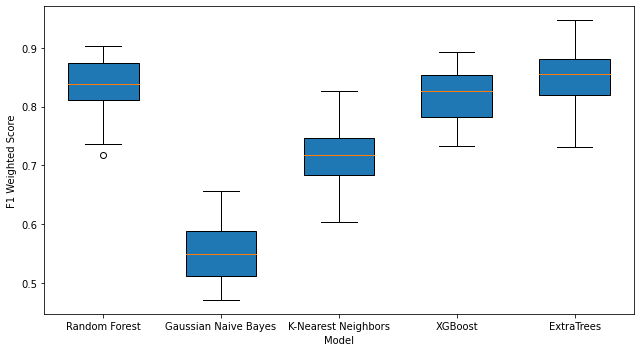

In [6]:
# Let's visualize the scores using box plot of cross validation of the models.
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

names = ["Random Forest", "Gaussian Naive Bayes", "K-Nearest Neighbors", "XGBoost", "ExtraTrees"]
models = [RandomForestClassifier(), GaussianNB(), KNeighborsClassifier(),
          GradientBoostingClassifier(), ExtraTreesClassifier()]

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(111)

skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=10)
for i, name, model in zip(range(0, 5), names, models):
    scores = cross_val_score(model, pivoted_df.drop(columns=['VesselTypeGroup']), pivoted_df['VesselTypeGroup'],
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i], vert=True,widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("F1 Weighted Score")
ax.set_xlabel("Model")
plt.tight_layout()